In [1]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import random

random.seed(10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## First, we load the dataset.

In [2]:
import json
import pandas as pd

label2id = {
    'NONE': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

def load_corpus(path, label_mapping=None):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels, eucall, objective = [], [], [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        eucall.append(corpus[abstract]['eu_call'])
        objective.append(corpus[abstract]['project_objective'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels, eucall, objective),
        columns=['document', 'sentences', 'labels','eu_call','project_objective'])

    return data

data = load_corpus('dataset_aueb_argument_v3.json') #, label_mapping=label2id)
print(f'Dataset length: {len(data)} abstracts')
data.sample(5)

Dataset length: 1017 abstracts


,document,sentences,labels,eu_call,project_objective
148,doi: 10.1016/j.clinbiomech.2019.06.004,[The effect of boundary and loading conditions...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.1.4.1.3.,This Centre of Excellence will advance the rol...
493,doi: 10.1038/s41598-020-57790-5,[Unraveling the choice of the north Atlantic s...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.3.5.1.,The European Climate Prediction system project...
198,doi: 10.1016/j.gloenvcha.2020.102063,[Multi-method evidence for when and how climat...,"[NEITHER, CLAIM, CLAIM, CLAIM, CLAIM, CLAIM, E...",H2020-EU.3.5.1.,CONSTRAIN will focus research on three climate...
55,doi: 10.1002/hep.30986,[qFIBS: A Novel Automated Technique for Quanti...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, CLAIM]",H2020-EU.3.1.1.,Strongly associated with the epidemics of obes...
816,doi: 10.1186/s40246-018-0177-z,[Impact of ZBTB7A hypomethylation and expressi...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.3.1.6.,Pharmacogenomics is the study of genetic varia...


In [3]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences

,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoas...
1,0,Importance Visual assessment of amyloid positr...
2,0,Several immunoassays have been developed to me...
3,0,The agreement between CSF Aβ42 measures from d...
4,0,Objective To determine the concordance between...
...,...,...
10570,1016,"Instead, SBPs sample a range of conformations ..."
10571,1016,Certain non-transported ligands leave the stru...
10572,1016,"Intriguingly, in some cases, similar SBP confo..."
10573,1016,"In this case, the inability for transport aris..."


In [4]:
#@title and the corresponding labels
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,NEITHER
1,0,NEITHER
2,0,NEITHER
3,0,NEITHER
4,0,NEITHER
...,...,...
10570,1016,NEITHER
10571,1016,NEITHER
10572,1016,NEITHER
10573,1016,NEITHER


In [5]:
data['sentences'] = [','.join(map(str, l)) for l in data['sentences']] #convert sentences column from list to str
data.head()

,document,sentences,labels,eu_call,project_objective
0,doi: 10.1001/jamaneurol.2017.2814,Concordance Between Different Amyloid Immunoas...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...
1,doi: 10.1001/jamaneurol.2017.4913,Association of Changes in Plasma Neurofilament...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.1.1.,Critical to our understanding of Alzheimer’s d...
2,doi: 10.1002/2015gl067056,Dynamically triggered slip leading to sustaine...,"[NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE...",H2020-EU.1.3.2.,Fluid overpressure has been proposed as one of...
3,doi: 10.1002/2015ms000564,Impacts of parameterized orographic drag on th...,"[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.1.3.2.,Circulation changes are at the heart of change...
4,doi: 10.1002/2016gl069551,"Climate model biases in jet streams, blocking ...","[NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...",H2020-EU.1.3.2.,Circulation changes are at the heart of change...


# Create document embeddings



In [6]:
max_words = 15_000  # We will only consider the 15K most used words in this dataset

# Setting up Keras tokenizer
document_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')

document_tokenizer

In [7]:
# this is like the .fit() that we call we using Scikit-learn and Count-Vectorizer
document_tokenizer.fit_on_texts(data['sentences'])  # Generate tokens by counting frequency
sequences = document_tokenizer.texts_to_sequences(data['sentences'])

In [8]:
# To proceed, we now have to make sure that all text sequences we feed into the model
# have the same length.
# We can do this with Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.
# Make all sequences 500 words long
maxlen = 500
document_emb = pad_sequences(sequences, maxlen=maxlen,padding='post')
print('New data shape: {}'.format(document_emb.shape))

New data shape: (1017, 500)


## Choose number of cluster for document embeddings

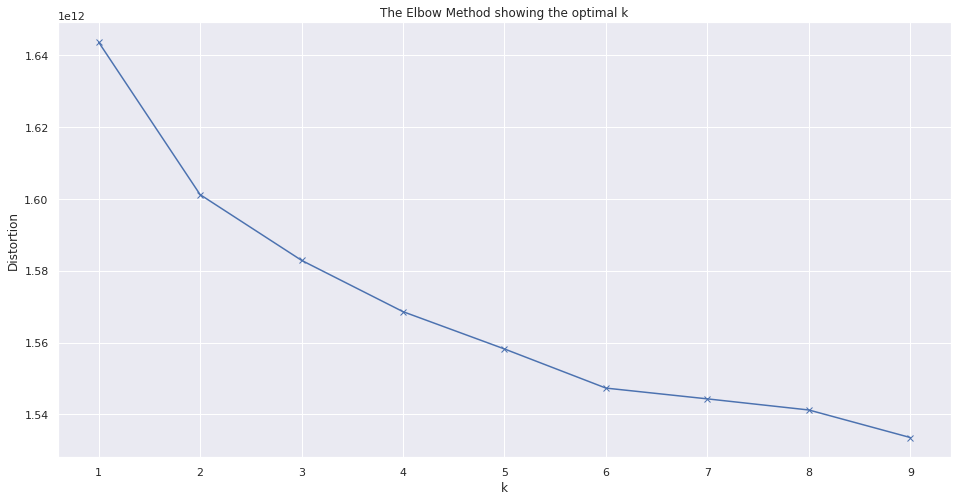

In [73]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel =KMeans(n_clusters=k, random_state=3)
    kmeanModel.fit(document_emb)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
def get_key(val,dic):
    for key, value in dic.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [74]:
kmeans=KMeans(n_clusters=6, random_state=3).fit(document_emb)
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = document_tokenizer.word_index
for i in range(6):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
     print(' %s' % get_key(ind,terms) , end='')
    print()

Top terms per cluster:
Cluster 0: population time key doesn't exist when observed important number provide low concentration activity function mean available expression
Cluster 1: als values across levels 12 free groups they natural measured lipid further independent performed material
Cluster 2: af all may be low observed but zikv specific key doesn't exist well cell most including with
Cluster 3: limited participants presence assess ra follow included analyses four activation natural process conclusion against increasing
Cluster 4: mechanisms most present 4 8 control total in increase up first we levels concentrations key doesn't exist
Cluster 5: key doesn't exist that in we and an 2 high from 5 has their as to were


## Visualize clusters for document embeddings

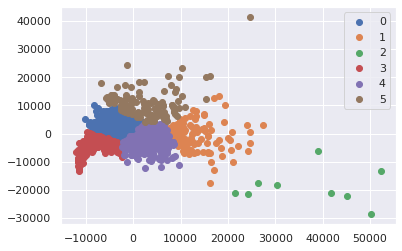

In [80]:
from sklearn.decomposition import PCA
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(document_emb)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters=6,random_state=3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

## Document embeddings + project objective embeddings

We didn't create document embeddings for the EUcall since we decided not to take them into consideration for the clustering combinations.

In [22]:
#create a dataset with Document embeddings + project objective columns
L = [data['sentences'],data['project_objective']]  
doc_sentences_objective=pd.concat(L,axis=1)

print(data['sentences'].shape)
print(data['project_objective'].shape)
print(doc_sentences_objective.shape)


(1017,)
(1017,)
(1017, 2)


In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
#remove stop words from projec_objective sentences
data['project_objective'] = data['project_objective'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
max_words = 15_000  # We will only consider the 15K most used words in this dataset

# Setting up Keras tokenizer
objective_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')

objective_tokenizer

In [25]:
# this is like the .fit() that we call we using Scikit-learn and Count-Vectorizer
objective_tokenizer.fit_on_texts(data['project_objective'])  # Generate tokens by counting frequency
sequences = objective_tokenizer.texts_to_sequences(data['project_objective'])


In [26]:
# To proceed, we now have to make sure that all text sequences we feed into the model
# have the same length.

# We can do this with Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.

# Make all sequences 100 words long
maxlen = 300

objective_emb = pad_sequences(sequences, maxlen=maxlen,padding='post')
# We have 25K, 100 word sequences now
print('New data shape: {}'.format(objective_emb.shape))

New data shape: (1017, 300)


In [27]:
#create a np array combining document embeddings and project objective embeddings
doc_objective_emb=np.concatenate((document_emb, objective_emb),axis=1)

## Choose number of cluster for document and project objective embeddings


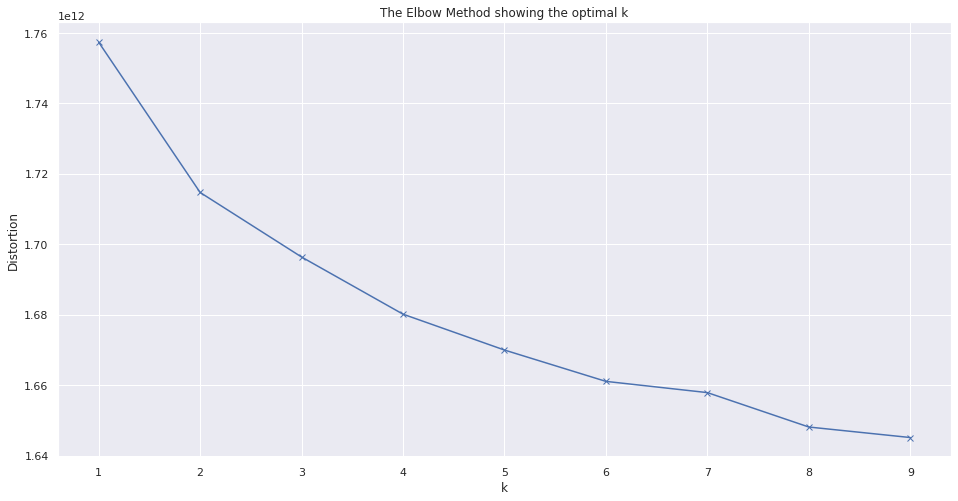

In [75]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=3)
    kmeanModel.fit(doc_objective_emb)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [76]:
kmeans=KMeans(n_clusters=6,random_state=3).fit(doc_objective_emb)
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = document_tokenizer.word_index
for i in range(6):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
     print(' %s' % get_key(ind,terms) , end='')
    print()

Top terms per cluster:
Cluster 0: on key doesn't exist blood be that all to but methods however based other 4 into from
Cluster 1: values many als  0 serum pressure there each changes european association forcing fatty t provide
Cluster 2: key doesn't exist number observed population expression time mean cells increase concentrations genes its low single those
Cluster 3: low resolution higher all surface levels potential changes large may most approach system genetic change
Cluster 4: free ci material concentration inflammation t known protein findings no fatty 001 analyses conclusion increasing
Cluster 5: key doesn't exist we their from 0 were that human as af and high with methods which


## Visualize clusters for document and project objective embeddings

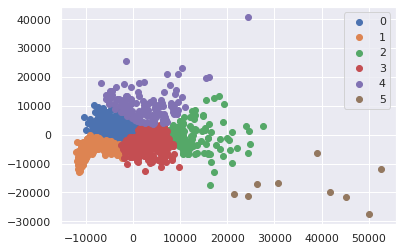

In [81]:

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(doc_objective_emb)
 
 
#Initialize the class object
kmeans = KMeans(n_clusters= 6,random_state=3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

## Document and claim Embeddings 

In [39]:
# Create a dataframe using only the claim sentences
sentences["label"]=labels["label"]
df_claim=sentences[sentences['label']=='CLAIM']
print(data['sentences'].shape)
print(df_claim['sentence'].shape)

(1017,)
(1048,)


In [40]:
max_words = 15_000  # We will only consider the 15K most used words in this dataset

# Setting up Keras tokenizer
claim_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')



In [41]:
# this is like the .fit() that we call we using Scikit-learn and Count-Vectorizer
claim_tokenizer.fit_on_texts(df_claim['sentence'])  # Generate tokens by counting frequency
sequences_cl = claim_tokenizer.texts_to_sequences(df_claim['sentence'])



In [42]:
# To proceed, we now have to make sure that all text sequences we feed into the model
# have the same length.
# We can do this with Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.
# Make all sequences 100 words long
maxlen = 100
claim_emb = pad_sequences(sequences_cl, maxlen=maxlen,padding='post')
print('New data shape: {}'.format(claim_emb.shape))

New data shape: (1048, 100)


In [43]:
#@title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences.head()

,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoas...
1,1,Association of Changes in Plasma Neurofilament...
2,2,Dynamically triggered slip leading to sustaine...
3,3,Impacts of parameterized orographic drag on th...
4,4,"Climate model biases in jet streams, blocking ..."


In [44]:
#create dataframe with claim emebdings and doc_id 
claims=pd.DataFrame(claim_emb)
claims['doc_id']=df_claim['doc_id'].to_list()
# use groupby and mean to calculate embeddings for each doc_id
claims=claims.groupby('doc_id').mean()
claims=claims.apply(pd.to_numeric)
documents=pd.DataFrame(document_emb)
documents['doc_id']=sentences['doc_id'].to_list()

In [45]:
#merge documents and claims embeddings
doc_claim = pd.merge(claims, documents, on="doc_id",how='left')
doc_claim=doc_claim.to_numpy()
doc_claim=doc_claim.astype(int)

## Choose number of cluster for document and claim embeddings

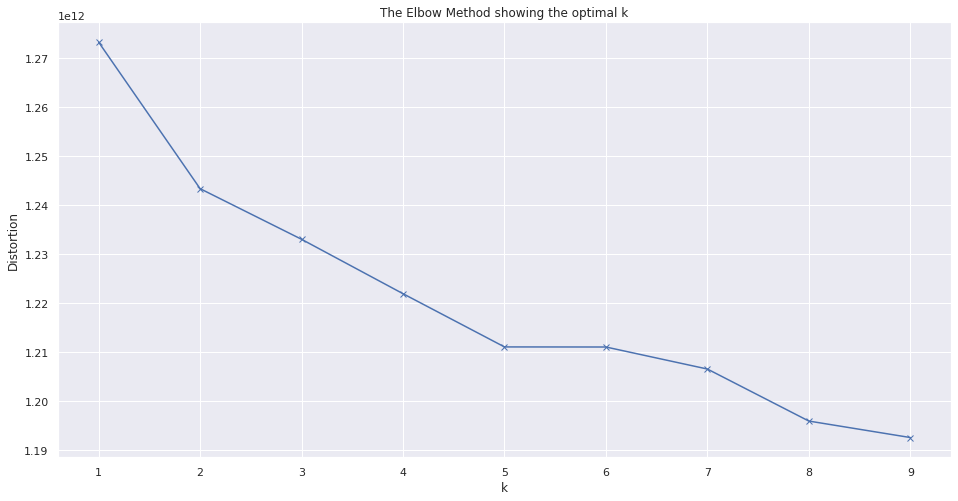

In [72]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=3)
    kmeanModel.fit(doc_claim)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [78]:
kmeans=KMeans(n_clusters=5,random_state=3).fit(doc_claim)
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = document_tokenizer.word_index
for i in range(5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
     print(' %s' % get_key(ind,terms) , end='')
    print()

Top terms per cluster:
Cluster 0: processes c level functional reduced cohort e state there diseases significantly impact scale provide how
Cluster 1: response resistance interactions mice 95 strong no could association highly known sea each after phase
Cluster 2: atmospheric order period insulin improve density uncertainty host 12 need receptor chemical common stress analyses
Cluster 3: species important response increase simulations gene fibrosis aerosol variability low virus resolution related csf through
Cluster 4: health binding precipitation material dynamics estimates i experiments values species measured four metabolic major response


## Visualize clusters for document and claim embeddings

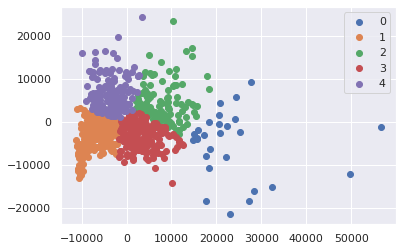

In [79]:

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(doc_claim)
 
#Initialize the class object
kmeans = KMeans(n_clusters= 5, random_state=3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()